In [129]:
import matplotlib.pyplot as plt
import torch
from torch import Tensor

In [127]:
teacher_log = torch.load("./logs/resnet20_cifar100.pt")
student_log = torch.load("./logs/resnet110_cifar100.pt")

In [126]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].plot(teacher_log["state"]["train"]["loss"], label="train")
# ax[0].plot(teacher_log["state"]["val"]["loss"], label="val")
# ax[1].plot(teacher_log["state"]["train"]["acc"], label="train")
# ax[1].plot(teacher_log["state"]["val"]["acc"], label="val")
# ax[2].plot(teacher_log["state"]["lr"])
# ax[0].set_title("Loss")
# ax[1].set_title("Acc")
# ax[0].legend()
# ax[1].legend()
# ax[2].set_title("Lr")
# plt.show()

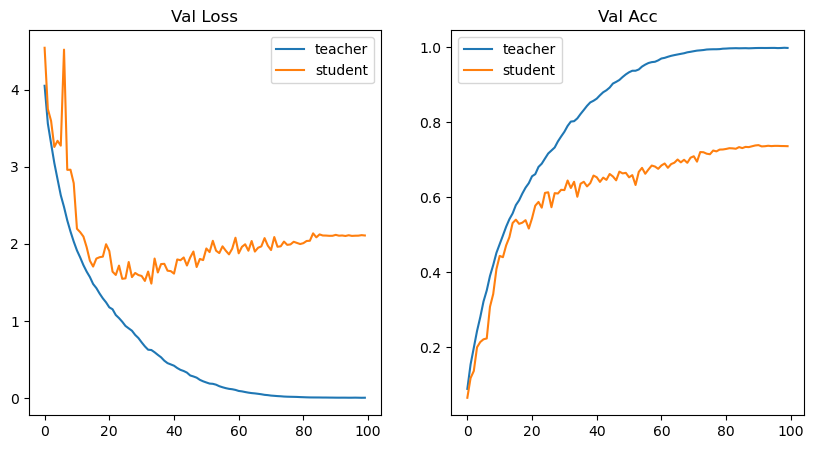

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(teacher_log["state"]["train"]["loss"], label="teacher")
ax[0].plot(student_log["state"]["val"]["loss"], label="student")
ax[1].plot(teacher_log["state"]["train"]["acc"], label="teacher")
ax[1].plot(student_log["state"]["val"]["acc"], label="student")
ax[0].set_title("Val Loss")
ax[1].set_title("Val Acc")
ax[0].legend()
ax[1].legend()
plt.show()

___

In [1]:
from networks import make_resnet
import torch

In [2]:
X = torch.randn(4, 3, 32, 32)

In [79]:
teacher, output_dim = make_resnet("resnet110", first_feature_maps=64, large=False)
student, output_dim = make_resnet("resnet20", first_feature_maps=64, large=False)

In [80]:
print(f"{teacher.num_params:,}")
print(f"{student.num_params:,}")

27,576,384
4,325,184


In [81]:
_, features_teacher = teacher(X, return_all_features=True)
_, features_student = student(X, return_all_features=True)

In [83]:
for ft, fs in zip(features_teacher, features_student):
    print(list(ft.shape), list(fs.shape))

[4, 64, 32, 32] [4, 64, 32, 32]
[4, 64, 32, 32] [4, 64, 32, 32]
[4, 64, 32, 32] [4, 64, 32, 32]
[4, 64, 32, 32] [4, 64, 32, 32]
[4, 64, 32, 32] [4, 128, 16, 16]
[4, 64, 32, 32] [4, 128, 16, 16]
[4, 64, 32, 32] [4, 128, 16, 16]
[4, 64, 32, 32] [4, 256, 8, 8]
[4, 64, 32, 32] [4, 256, 8, 8]
[4, 64, 32, 32] [4, 256, 8, 8]


In [99]:
from torchmetrics.functional import pairwise_cosine_similarity

In [131]:
# pas différentiable tel quel
def get_intra_similarity_matrices(features: Tensor) -> list[list[Tensor]]:
    " list (layer) of lists (batch elements) of sim matrices."
    sim_matrices = list()
    for layer_features in features:  # (l, b, c, h, w) ->  (b, c, h, w)
        layer_sim_matrices = list()
        for element_features in layer_features:  # (b, c, h, w) -> (c, h, w) 
            x = element_features.flatten(start_dim=1)  # (c, h, w) - > (c, h * w)
            sim_matrix = pairwise_cosine_similarity(x, x)  # (c, c)
            layer_sim_matrices.append(sim_matrix)
        sim_matrices.append(layer_sim_matrices)
    return sim_matrices

In [ ]:
#TODO: pas fonctionnel, il faut réflechir à ça
def get_inter_similarity_matrices(source_features: Tensor, target_features) -> list[list[Tensor]]:
    " list (layer) of lists (batch elements) of sim matrices."
    sim_matrices = list()
    for source_layer_features, target_layer_features in zip(source_features, target_features):  # (l, b, c, h, w) ->  (b, c, h, w)
        layer_sim_matrices = list()
        for source_element_features, target_element_features in zip(source_layer_features, target_layer_features):  # (b, c, h, w) -> (c, h, w) 
            x = element_features.flatten(start_dim=1)  # (c, h, w) - > (c, h * w)
            c = x.size(0)
            sim_matrix = pairwise_cosine_similarity(x, x)  # (c, c)
            layer_sim_matrices.append(sim_matrix)
        sim_matrices.append(layer_sim_matrices)
    return sim_matrices

In [132]:
sim_matrices_teacher = get_intra_similarity_matrices(features_teacher)
sim_matrices_student = get_intra_similarity_matrices(features_student)

In [112]:
# K = 4
# knn = test.topk(k=K)
# adjacency = torch.zeros(c, c)
# adjacency[torch.arange(c).repeat_interleave(K), knn.indices.flatten()] = knn.values.flatten()

In [77]:
import ot

In [118]:
for sim_teacher_layer, sim_student_layer in zip(sim_matrices_student, sim_matrices_teacher):
    for sim_teacher_element, sim_student_element in zip(sim_teacher_layer, sim_student_layer):
        p = ot.unif(len(sim_teacher_element), type_as=sim_teacher_element)
        q = ot.unif(len(sim_student_element), type_as=sim_student_element)
        gw, log = ot.gromov.gromov_wasserstein(sim_teacher_element, sim_student_element, p, q, 'square_loss', log=True)
        break
    break

In [123]:
gw.shape

torch.Size([64, 64])

In [120]:
log

{'loss': [0.03309309482574463, 0.017127837985754013, 0.017127837985754013],
 'cost': 0.05541315255686641,
 'u': tensor([0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277, 0.0277, 0.0277, 0.0277, 0.0276, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277, 0.0277,
         0.0277]),
 'v': tensor([0.0245, 0.0281, 0.0213, 0.0157, 0.0296, 0.0264, 0.0353, 0.0363, 0.0265,
         0.0323, 0.0289, 0.0269, 0.0228, 0.0229, 0.0299, 0.0349, 0.0297, 0.0251,
         0.0205, 0.0233, 0.0192, 0.0267, 0.0252, 0.0422, 0.0334, 0.0370, 0.0257,
         0.0268, 0.0295, 0.0259, 0.0280, 0.0281, 0.0286

___

In [86]:
import numpy as np
import scipy as sp

In [92]:
n_samples = 30  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4, 4])
cov_t = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])


xs = ot.datasets.make_2D_samples_gauss(n_samples, mu_s, cov_s)
P = sp.linalg.sqrtm(cov_t)
xt = np.random.randn(2 * n_samples, 3).dot(P) + mu_t

In [93]:
C1 = sp.spatial.distance.cdist(xs, xs)
C2 = sp.spatial.distance.cdist(xt, xt)

In [96]:
C1 /= C1.max()
C2 /= C2.max()

In [97]:
p = ot.unif(len(C1))
q = ot.unif(len(C2))

gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=True, log=True)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.499642e-02|0.000000e+00|0.000000e+00
    1|4.249765e-02|7.647190e-01|3.249876e-02
    2|3.222269e-02|3.188736e-01|1.027496e-02
    3|3.082694e-02|4.527703e-02|1.395752e-03
    4|2.971860e-02|3.729448e-02|1.108340e-03
    5|2.874170e-02|3.398872e-02|9.768937e-04
    6|2.684254e-02|7.075184e-02|1.899159e-03
    7|2.463325e-02|8.968730e-02|2.209290e-03
    8|2.300340e-02|7.085271e-02|1.629853e-03
    9|2.299199e-02|4.962557e-04|1.140991e-05
   10|2.299199e-02|0.000000e+00|0.000000e+00


(60, 60)